In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


-----
-----
## $f_2(x_1, x_2, x_3, x_4)$

##### $f_2(x_1, x_2, x_3, x_4) = \sin(\pi \cdot (x_1 \cdot x_2 + \tanh(x_1^2+x_2^2)))$

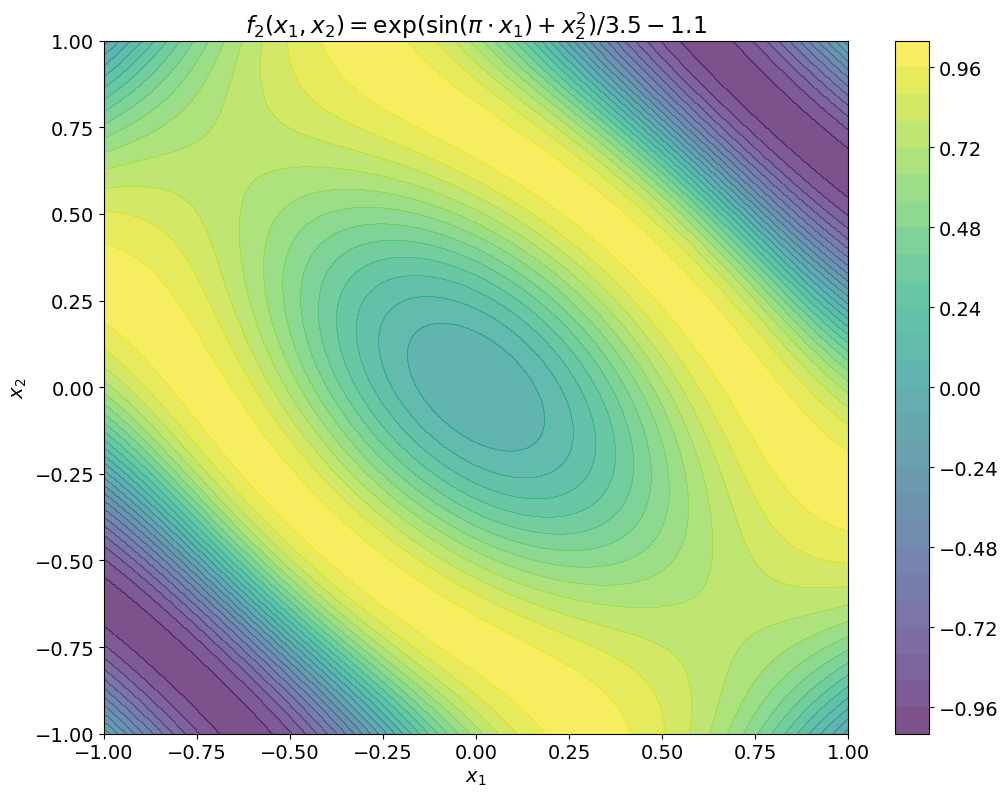

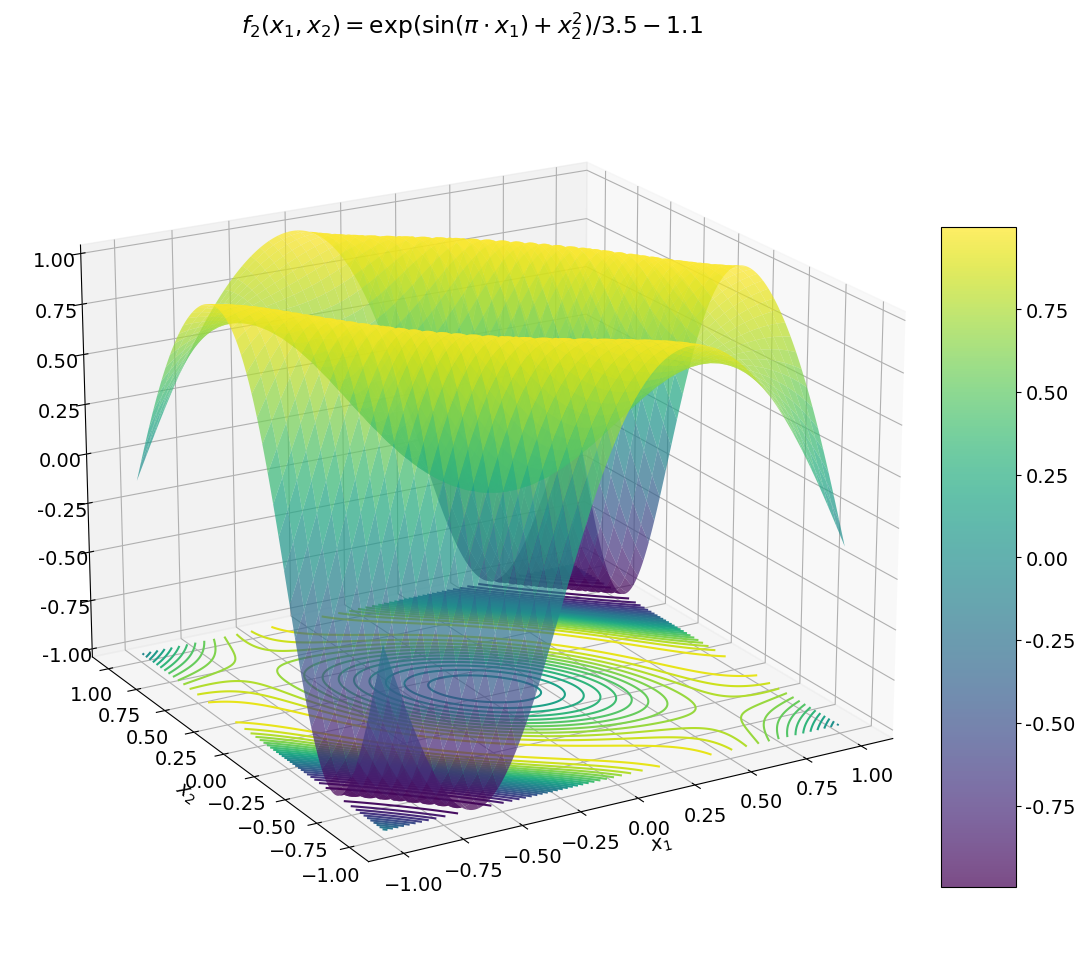

In [4]:
# create dataset
f2 = lambda x: torch.sin(torch.pi*( (x[:,[0]]*x[:,[1]]) + torch.tanh(x[:,[0]]**2 + x[:,[1]]**2) ))
dataset2 = create_dataset(f2, n_var=4, device=device)

f = f2
dataset = dataset2

plot_f_2d(f2, title='$f_2(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f2, title='$f_2(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_2$

№ model trainable params: 246


| train_loss: 7.81e-03 | test_loss: 1.26e-02 | reg: 1.11e+02 | : 100%|█| 100/100 [00:03<00:00, 25.15


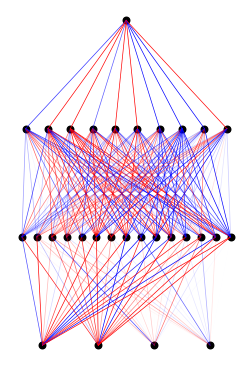

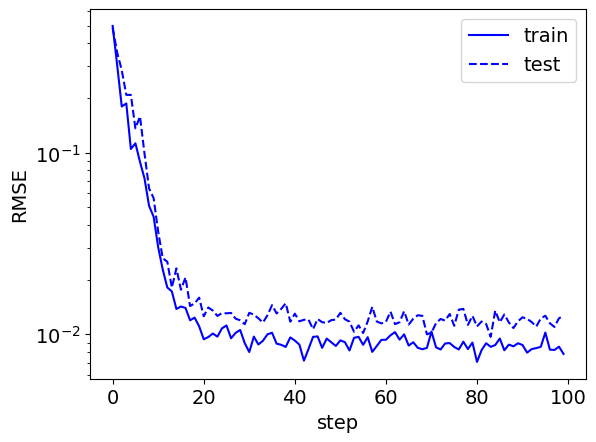

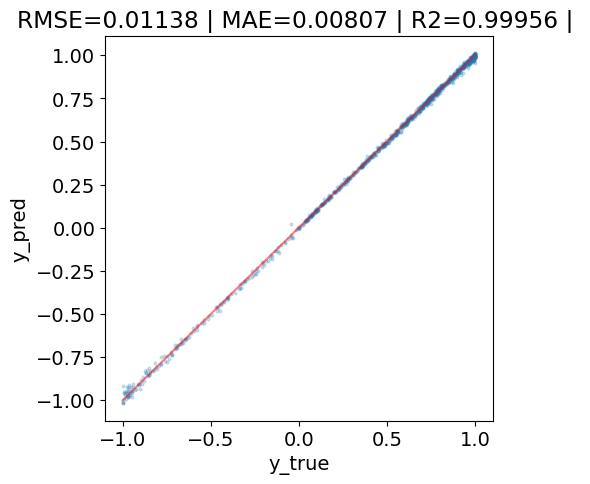

In [6]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_2$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 9.39e-03 | test_loss: 9.98e-03 | reg: 1.07e+01 | : 100%|█| 100/100 [00:32<00:00,  3.07


saving model version 0.1


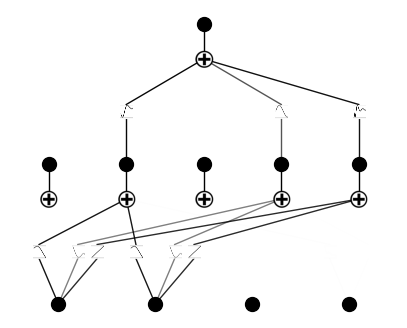

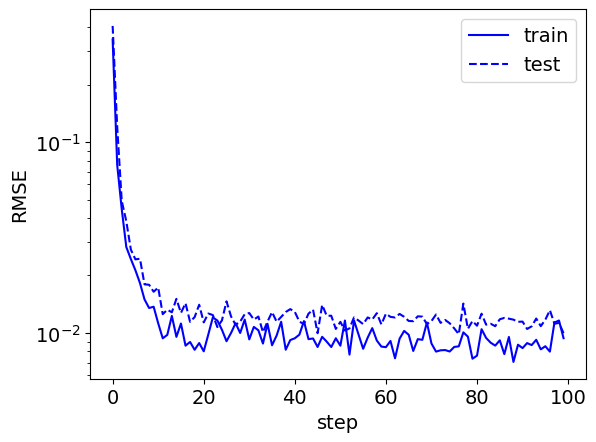

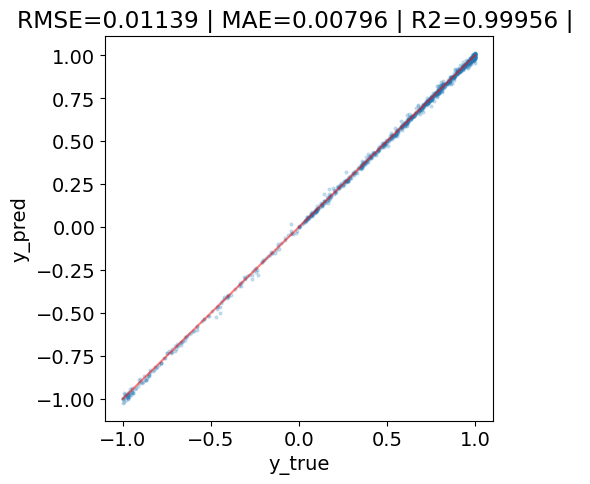

In [7]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### $\lambda$-KAN on $f_2$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.20e-02 | test_loss: 2.76e-02 | reg: 1.61e+01 | : 100%|█| 150/150 [00:52<00:00,  2.86


saving model version 0.1


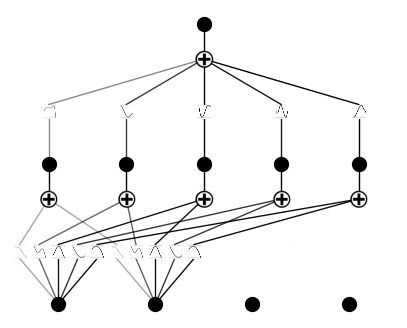

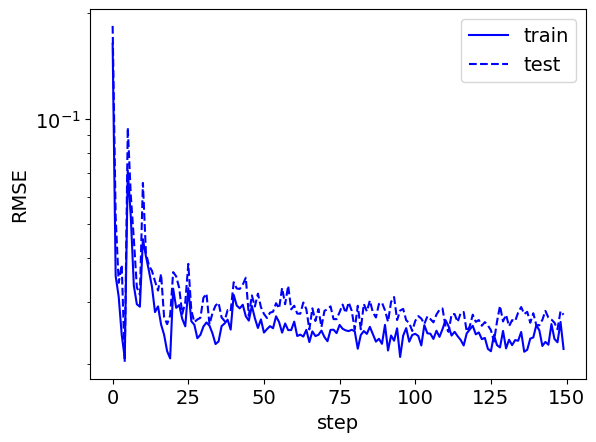

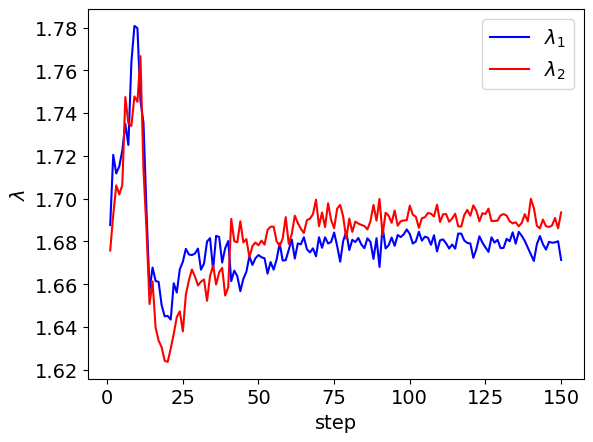

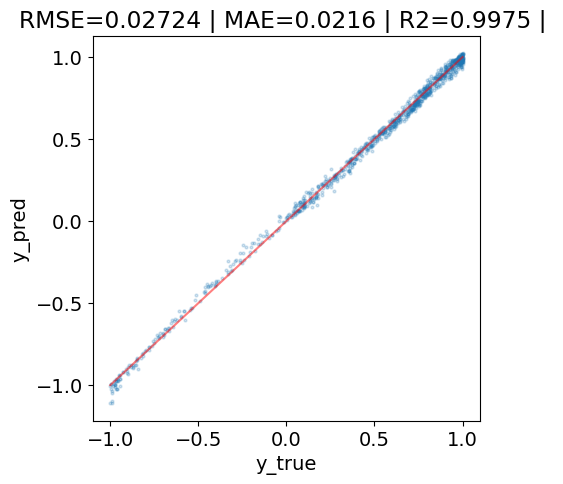

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.6713e+00,  1.6935e+00,  4.6824e-03, -5.8528e-05],
       requires_grad=True)


In [8]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:59, 16.10it/s]                          


module of Input importance:


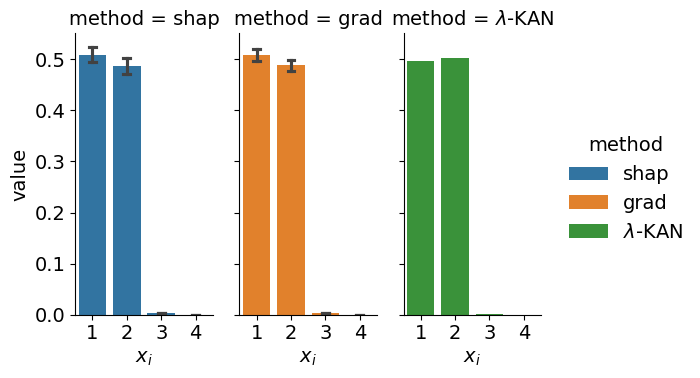

Input importance:


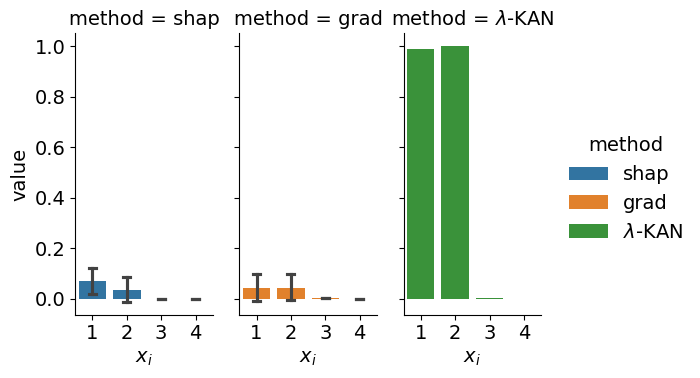

In [9]:
importance_analyse_lmdKAN(model, dataset)

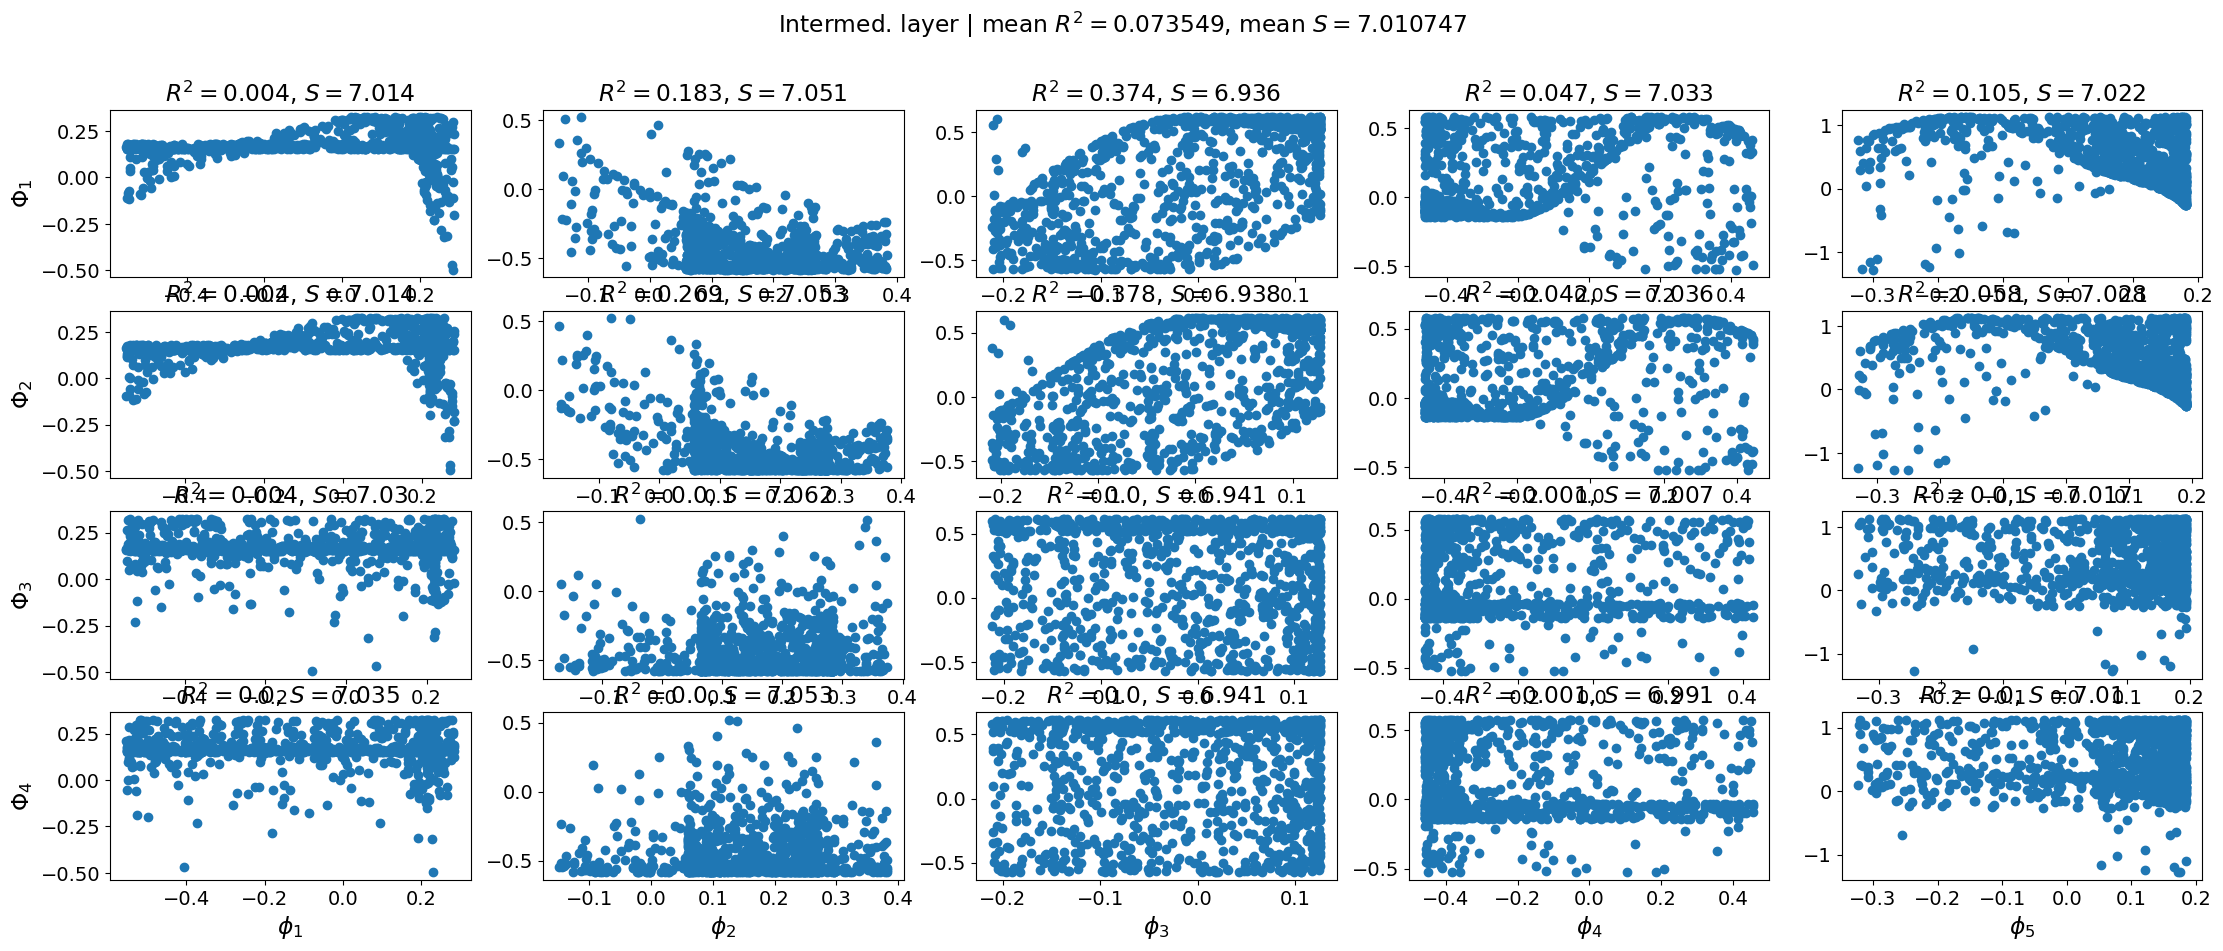

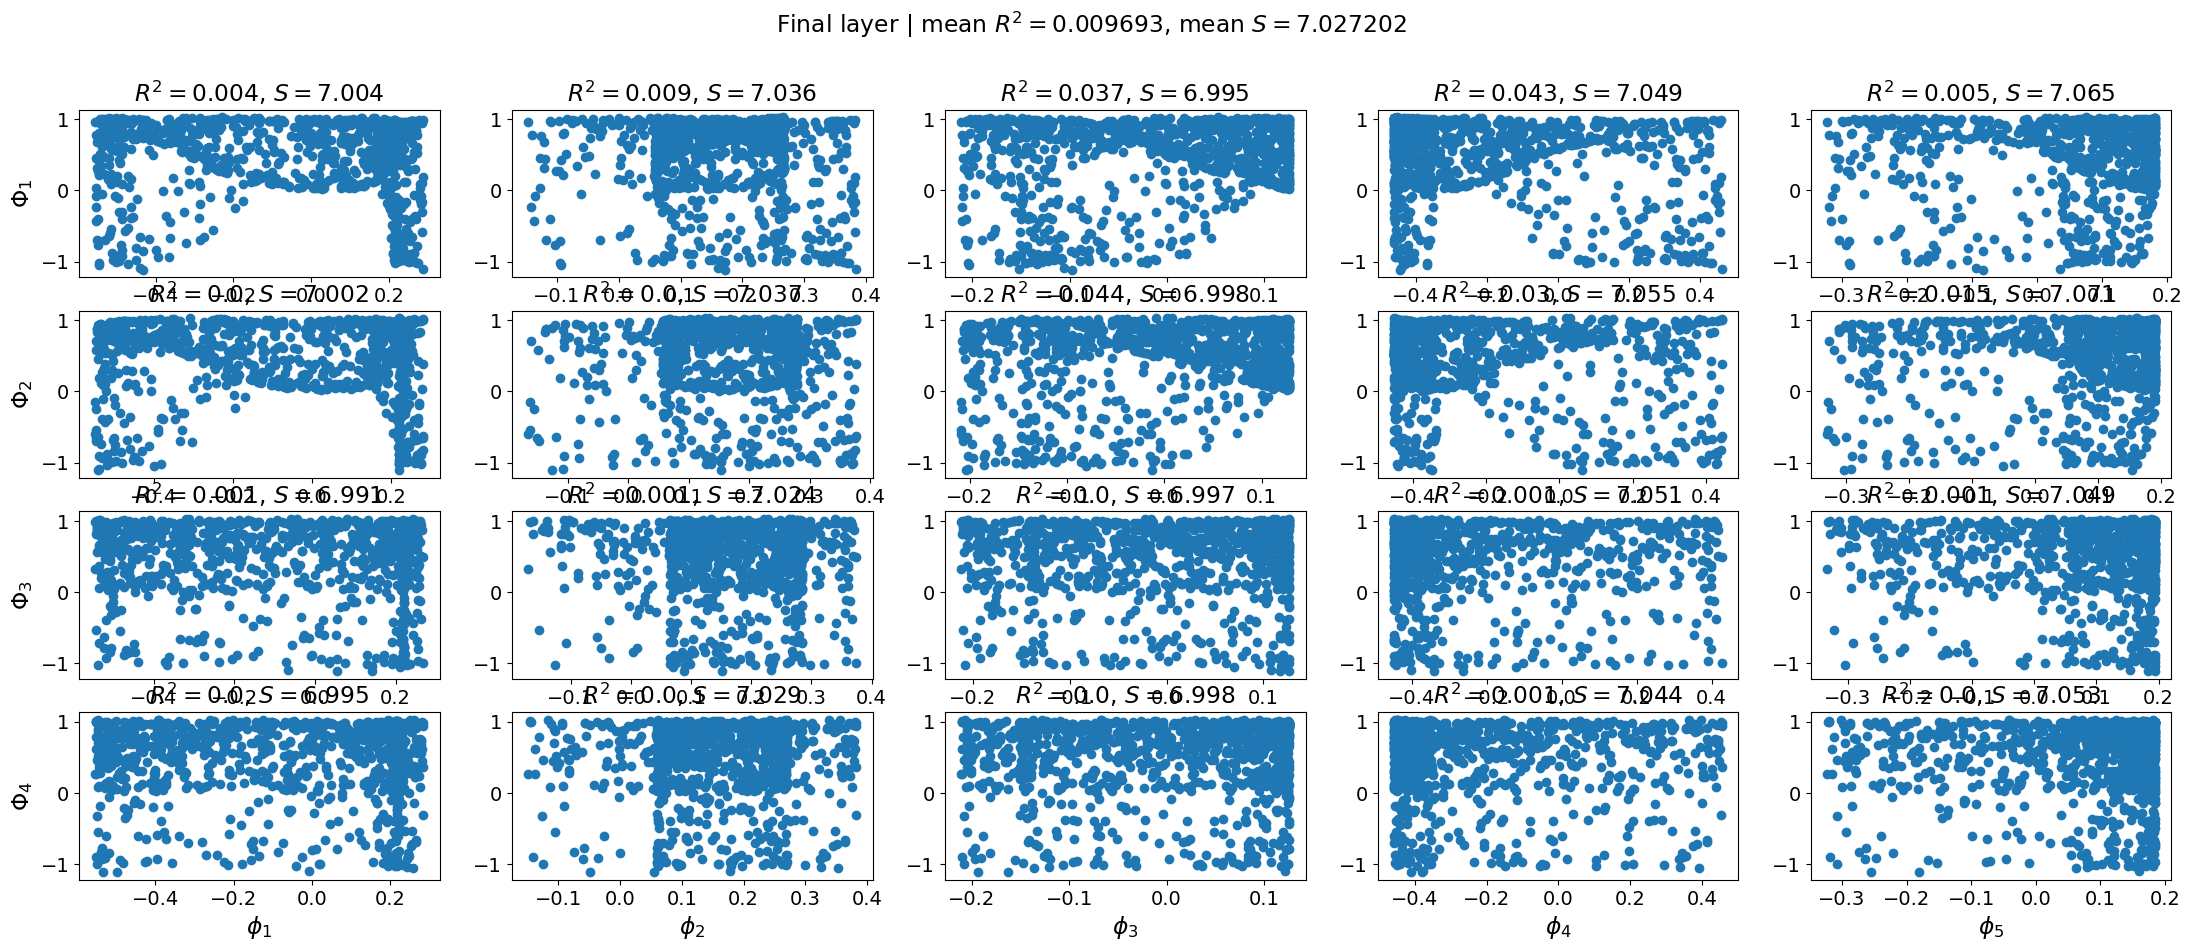

{'mean_r2': 0.009693175411848642, 'mean_matrix_entropy': 7.0272016525268555}

In [10]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN on $f_2$ with __R2 regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 2.72e-02 | test_loss: 3.40e-02 | reg: 9.72e+00 | : 100%|█| 150/150 [02:49<00:00,  1.13


saving model version 0.1


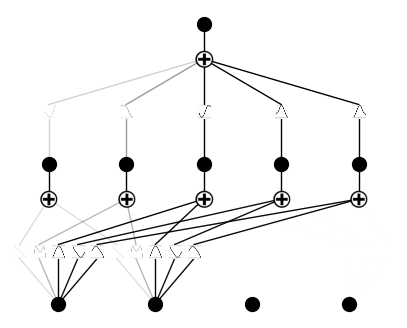

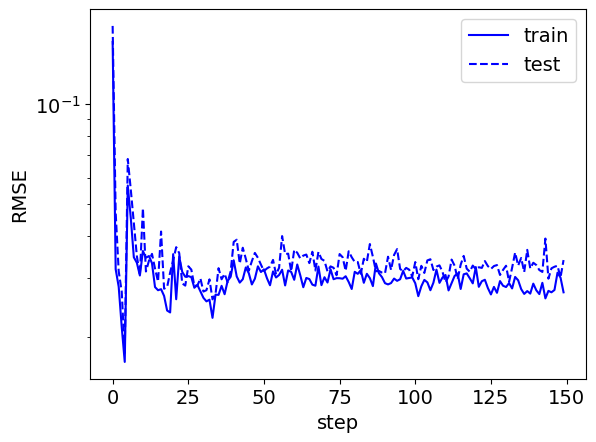

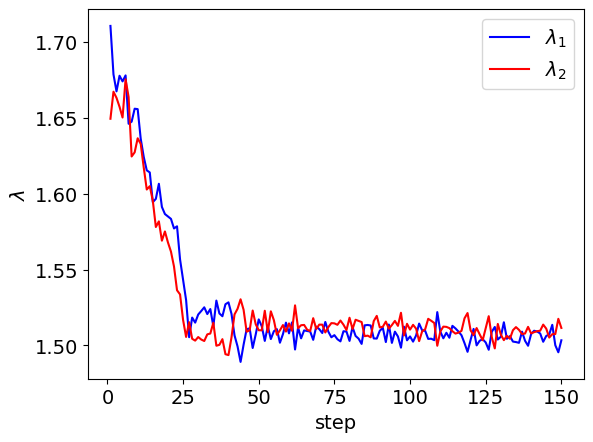

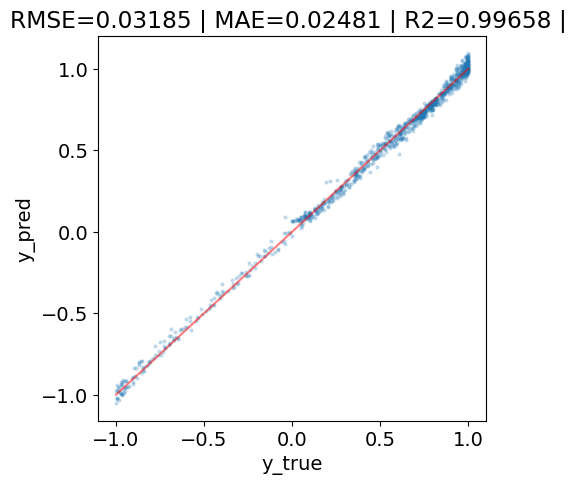

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.5034e+00,  1.5115e+00,  1.1665e-03, -2.5217e-03],
       requires_grad=True)


In [11]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:47, 17.49it/s]                         


module of Input importance:


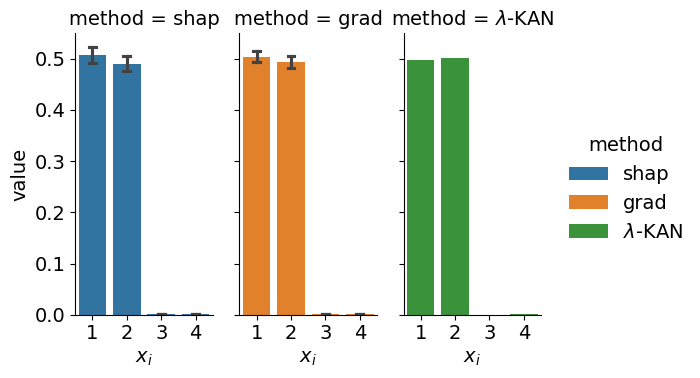

Input importance:


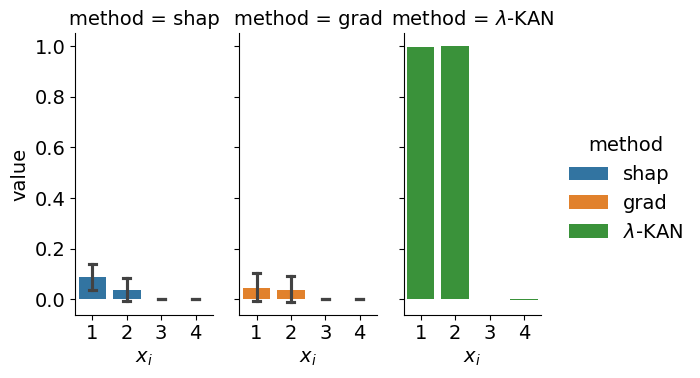

In [12]:
importance_analyse_lmdKAN(model, dataset)

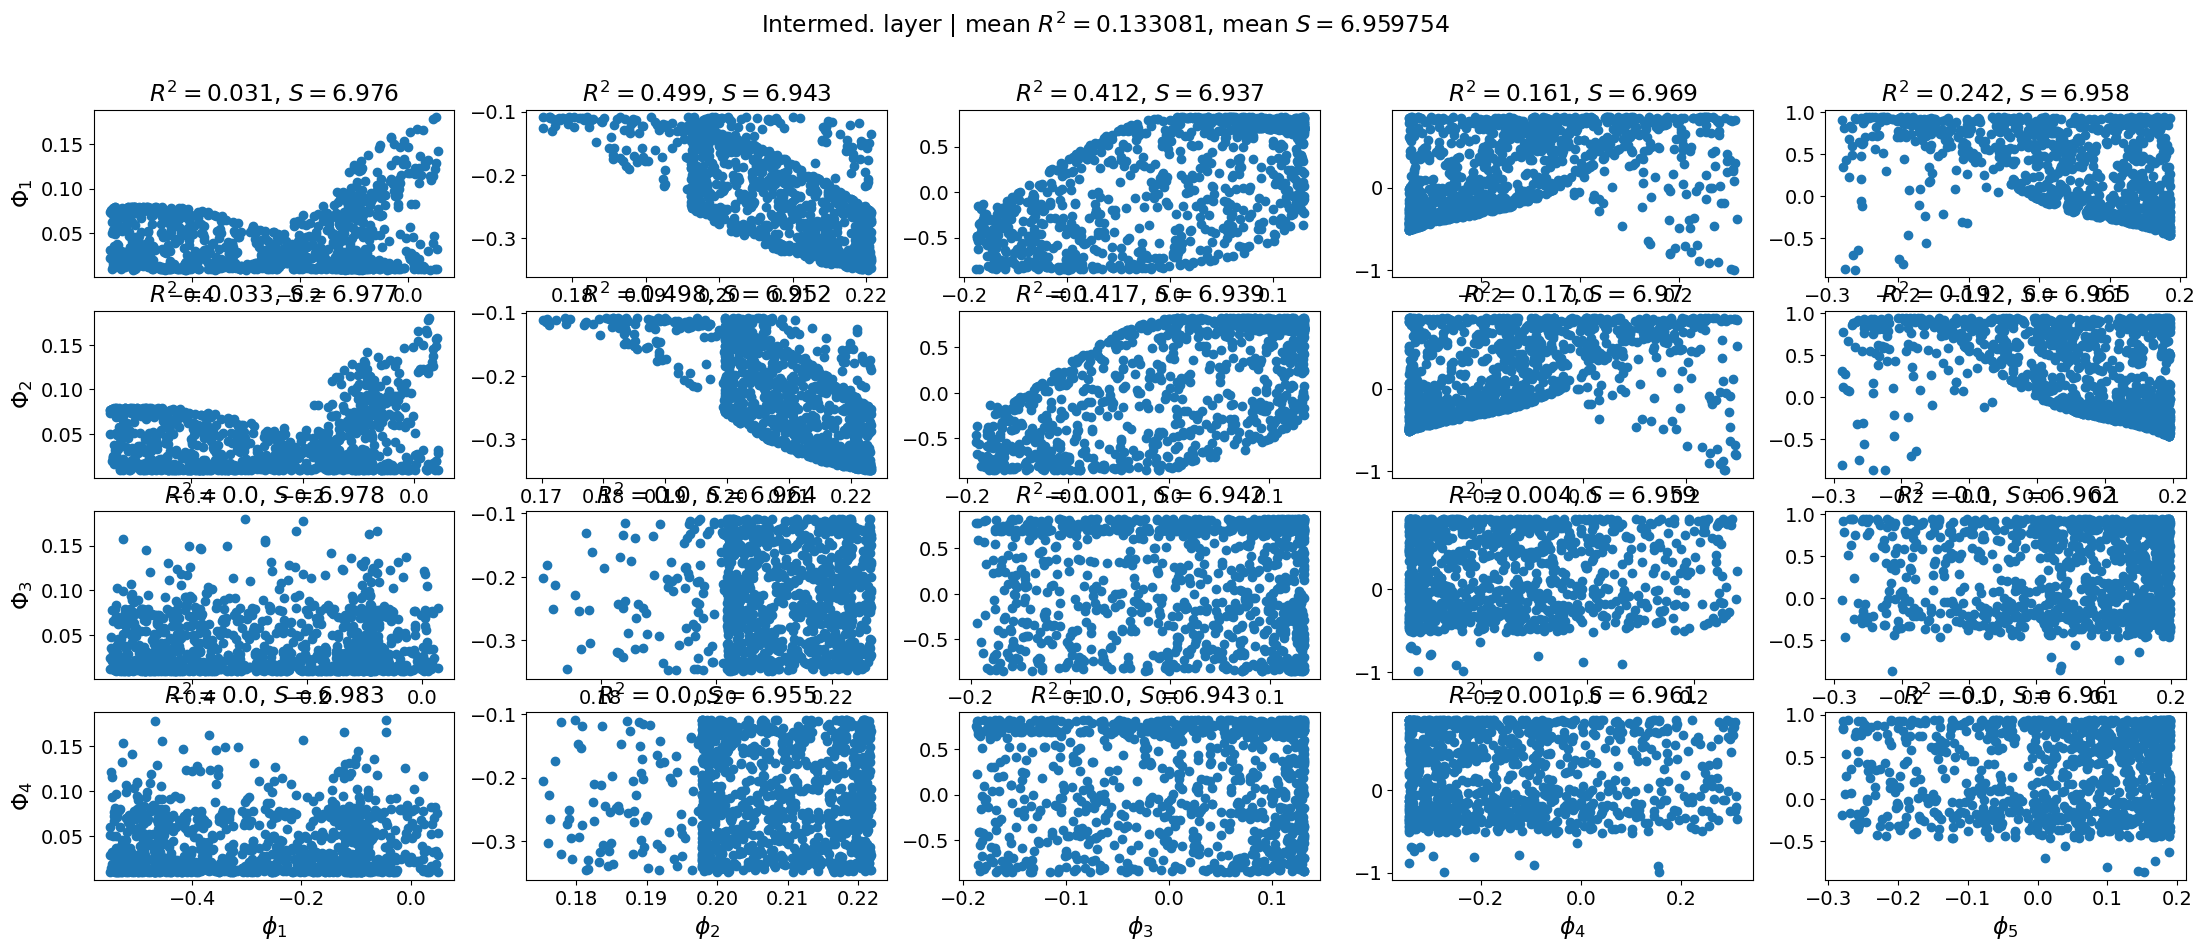

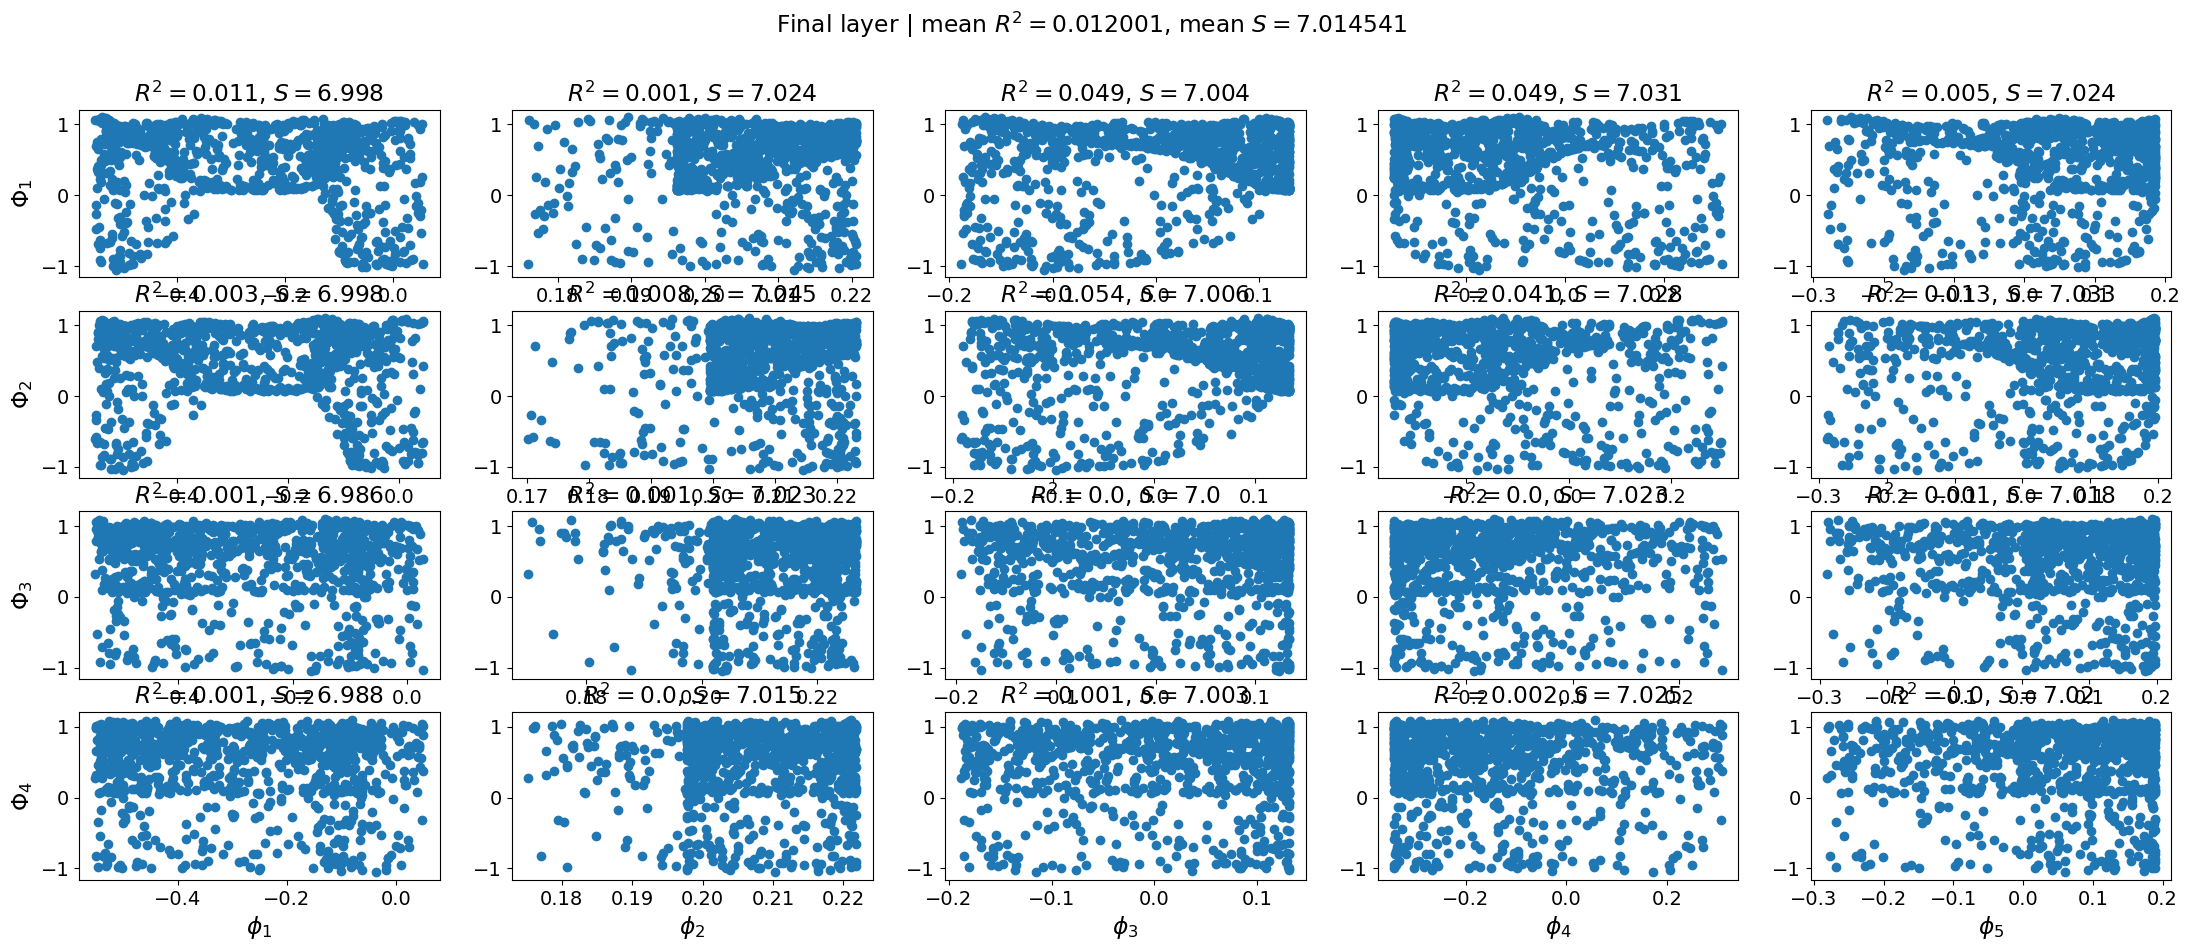

{'mean_r2': 0.012001486673864293, 'mean_matrix_entropy': 7.014540672302246}

In [13]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_2$ with __Entropy regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.36e-02 | test_loss: 2.89e-02 | reg: 1.09e+01 | : 100%|█| 150/150 [02:55<00:00,  1.17


saving model version 0.1


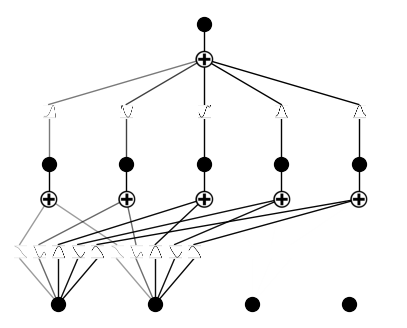

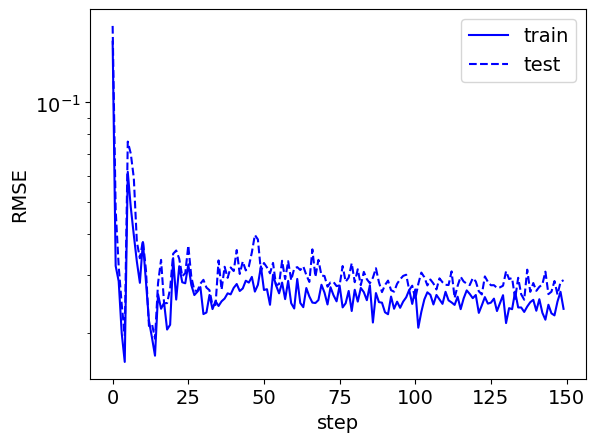

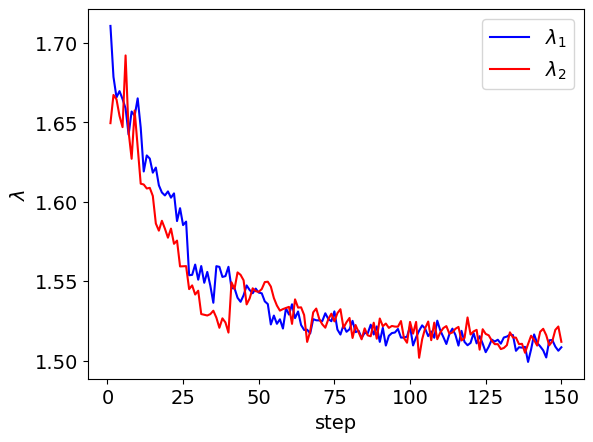

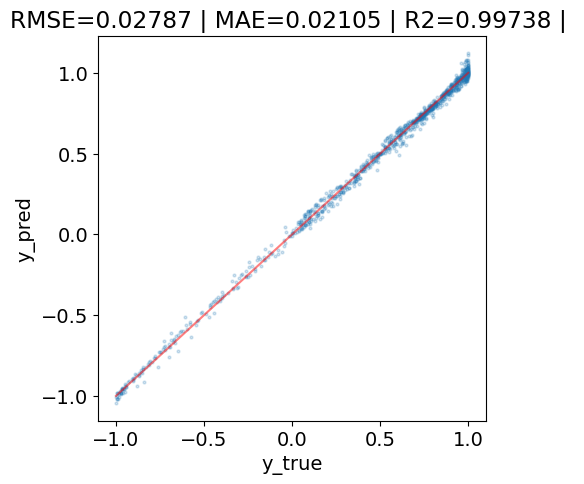

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.5083e+00,  1.5118e+00,  2.2782e-03, -3.3172e-04],
       requires_grad=True)


In [15]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:29, 23.31it/s]                         


module of Input importance:


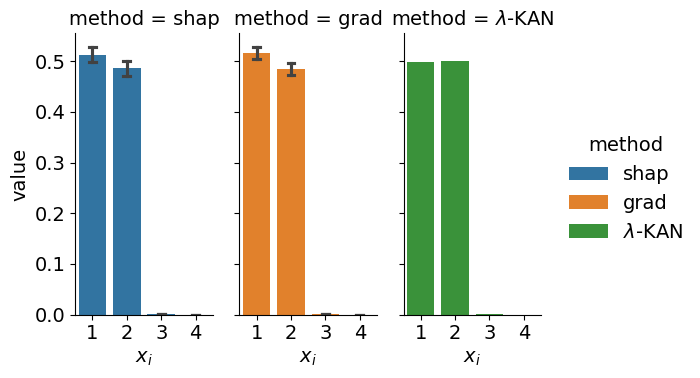

Input importance:


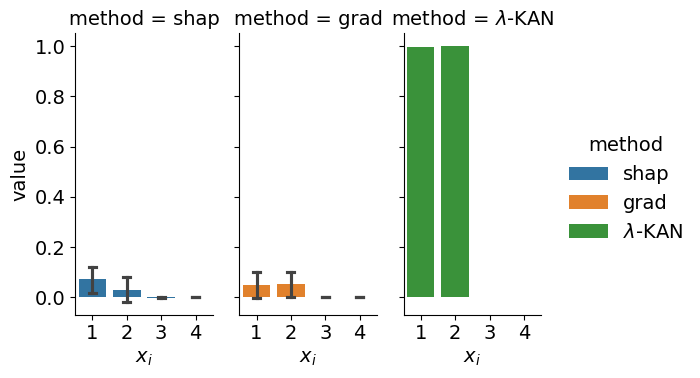

In [16]:
importance_analyse_lmdKAN(model, dataset)

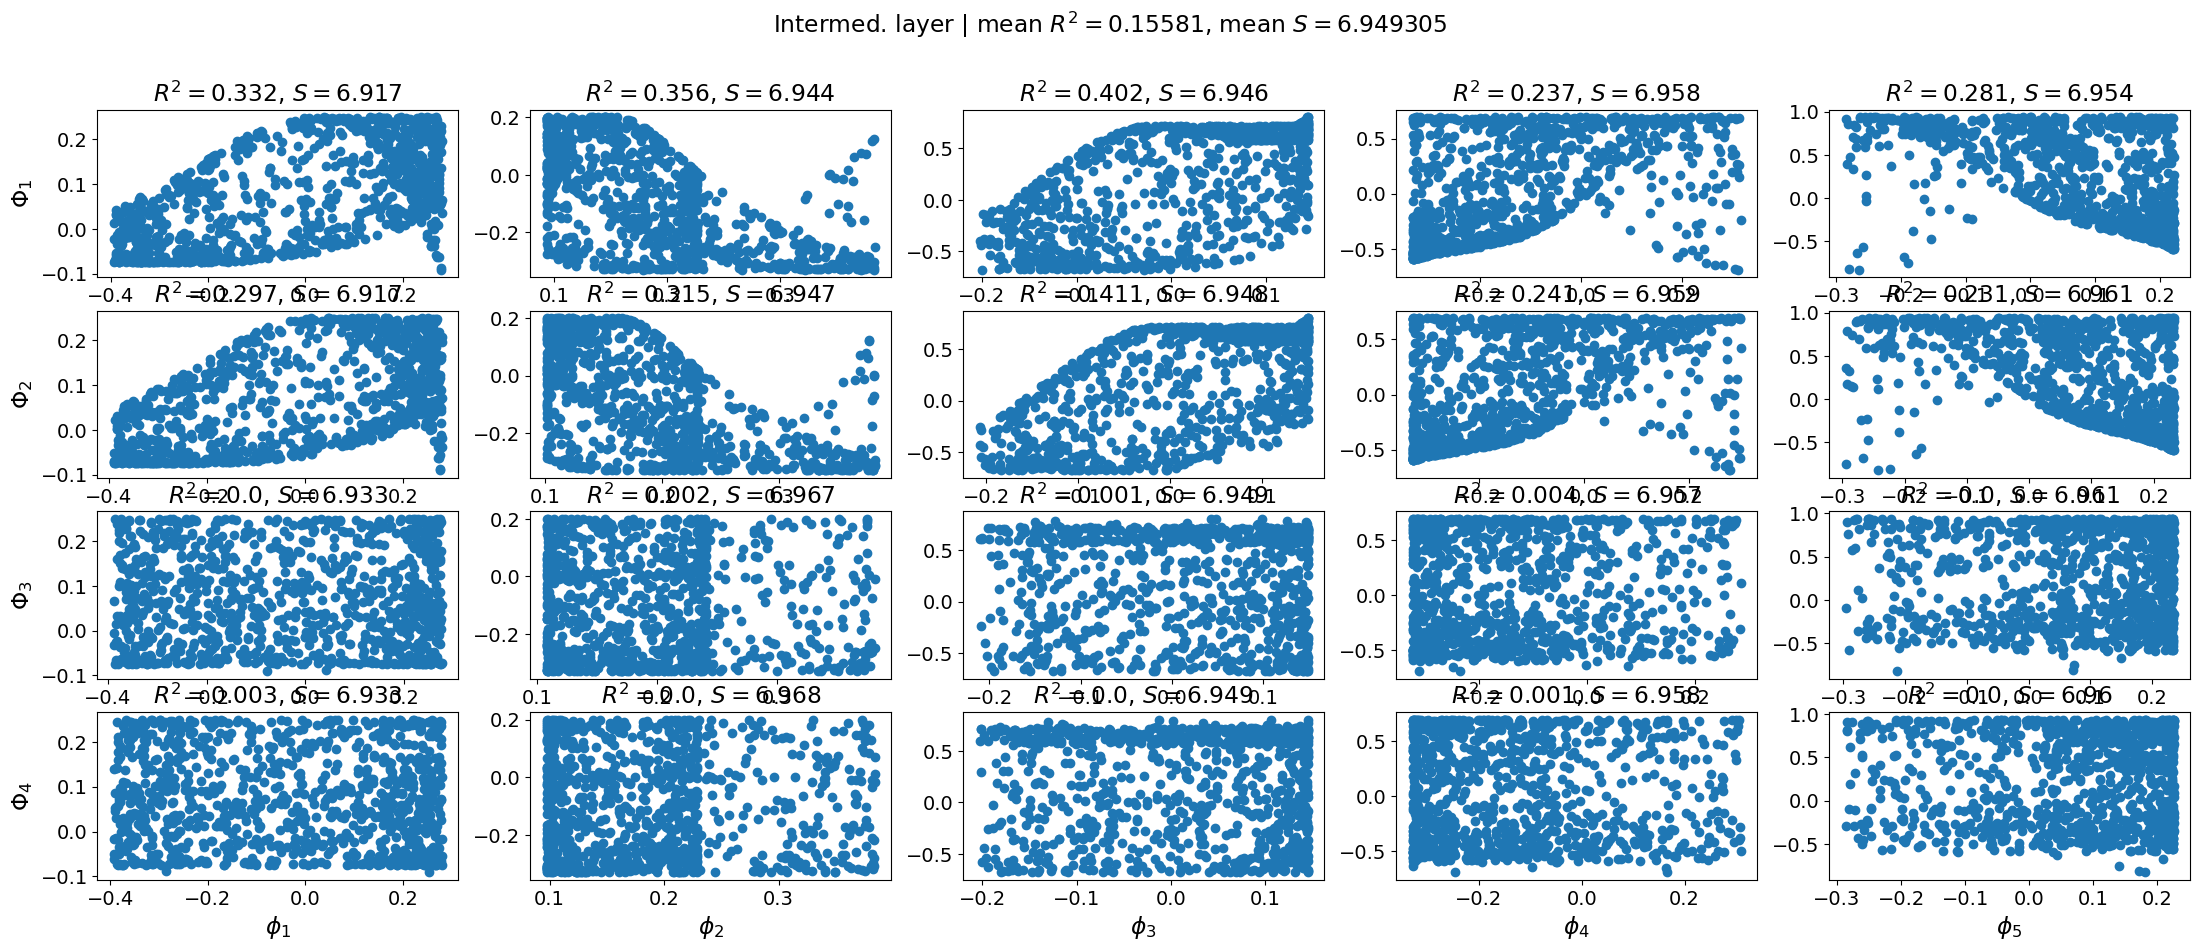

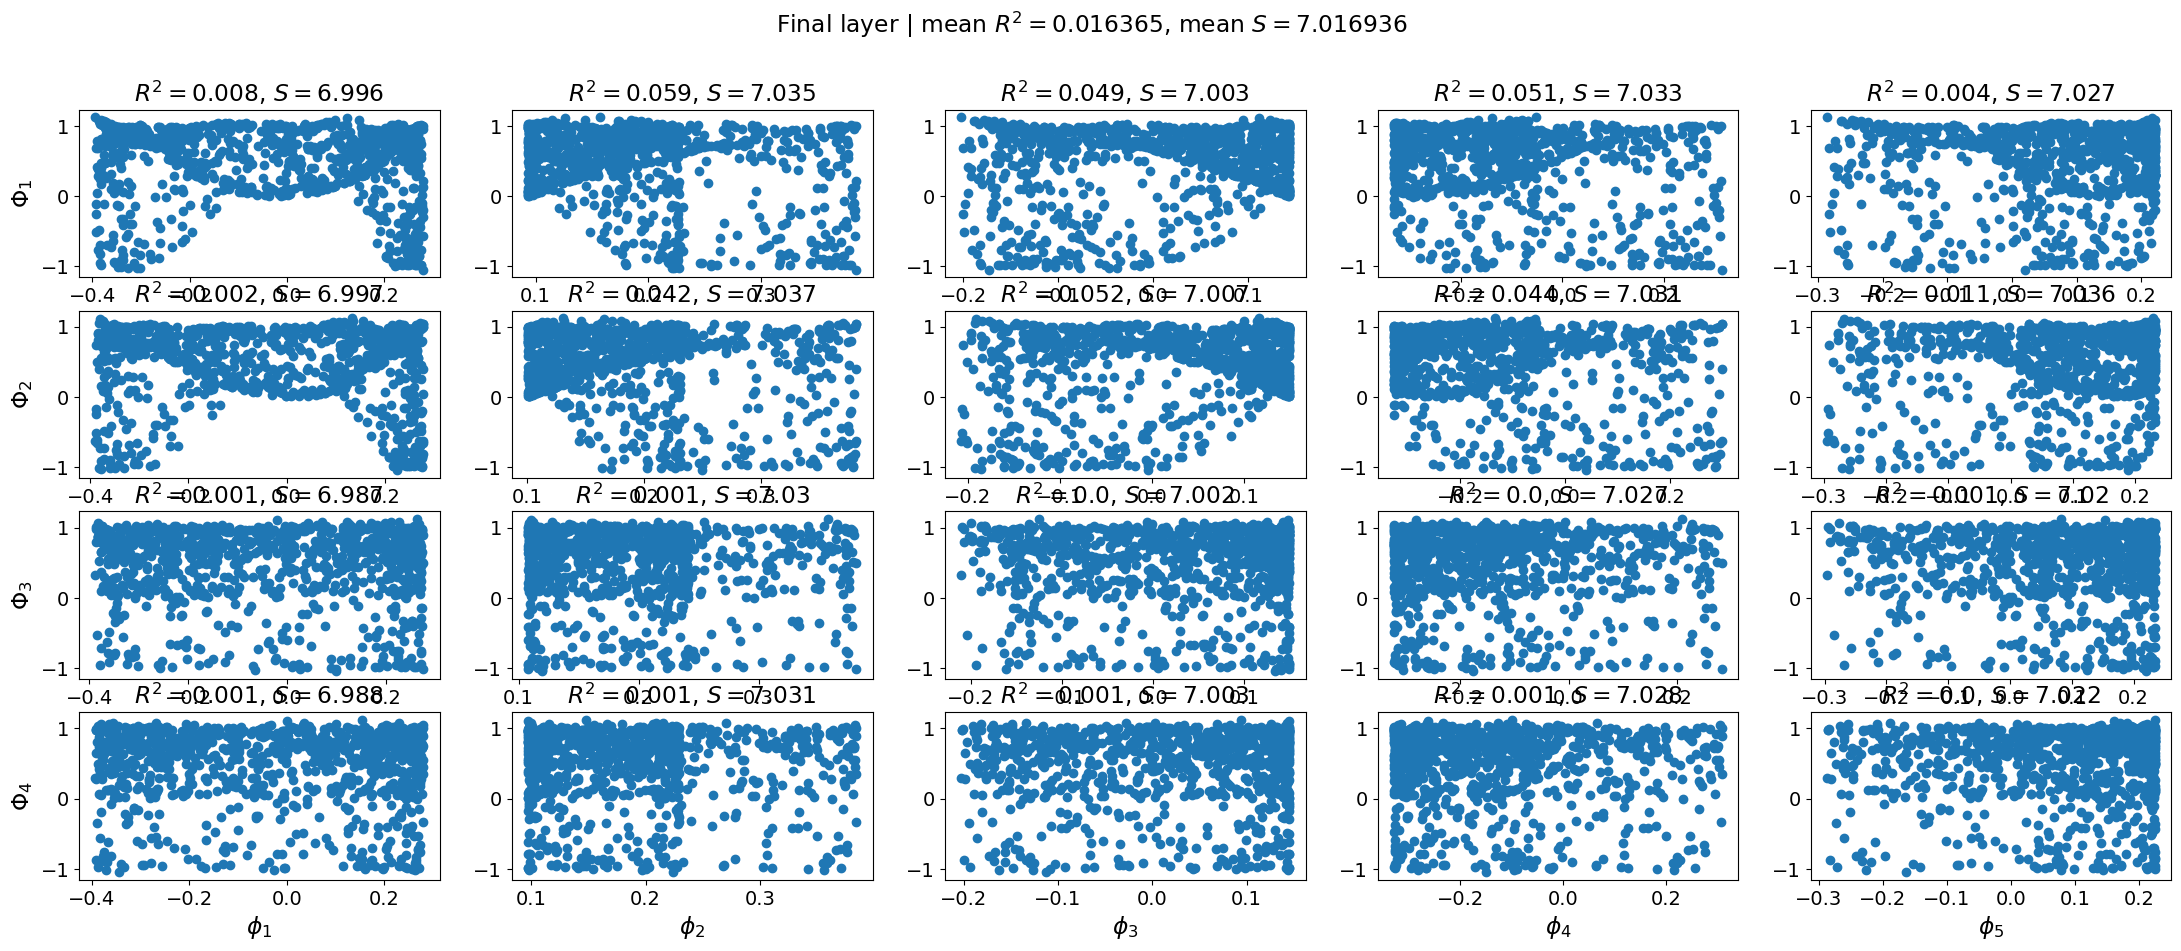

{'mean_r2': 0.016364814024439057, 'mean_matrix_entropy': 7.0169358253479}

In [17]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN on $f_2$ with __R2 regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 2.43e-02 | test_loss: 3.12e-02 | reg: 1.10e+01 | : 100%|█| 150/150 [03:14<00:00,  1.30


saving model version 0.1


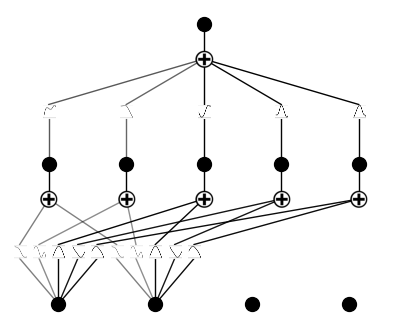

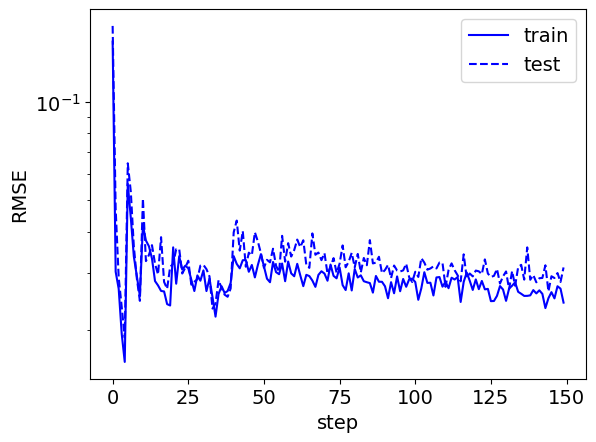

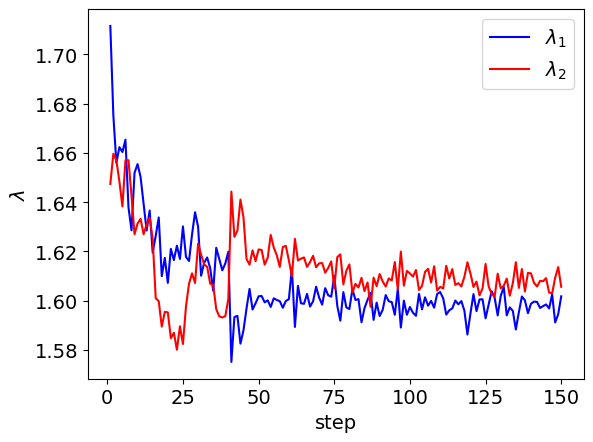

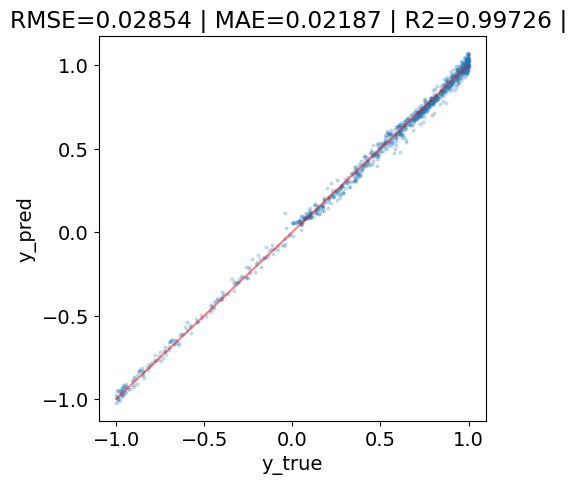

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.6018e+00,  1.6057e+00,  1.0562e-03, -4.9605e-04],
       requires_grad=True)


In [18]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:42, 18.61it/s]                         


module of Input importance:


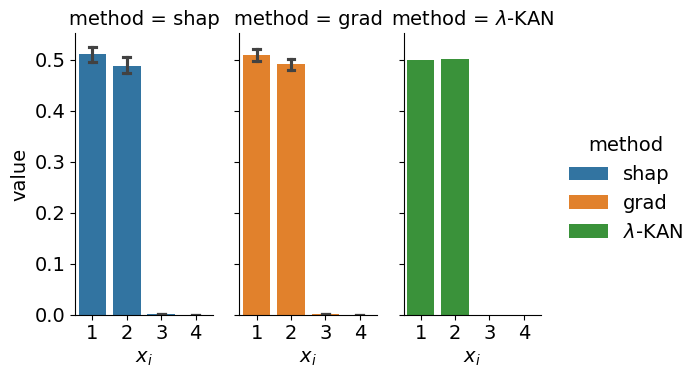

Input importance:


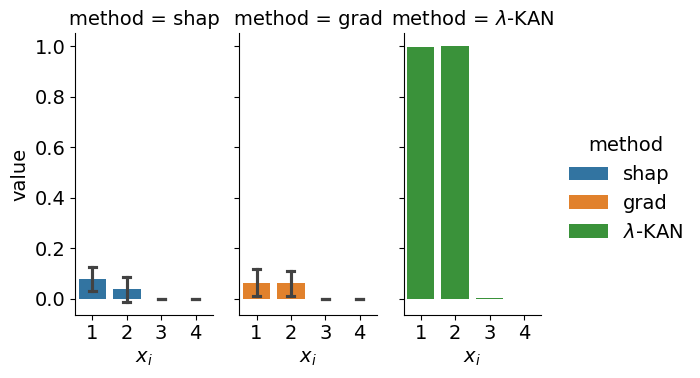

In [19]:
importance_analyse_lmdKAN(model, dataset)

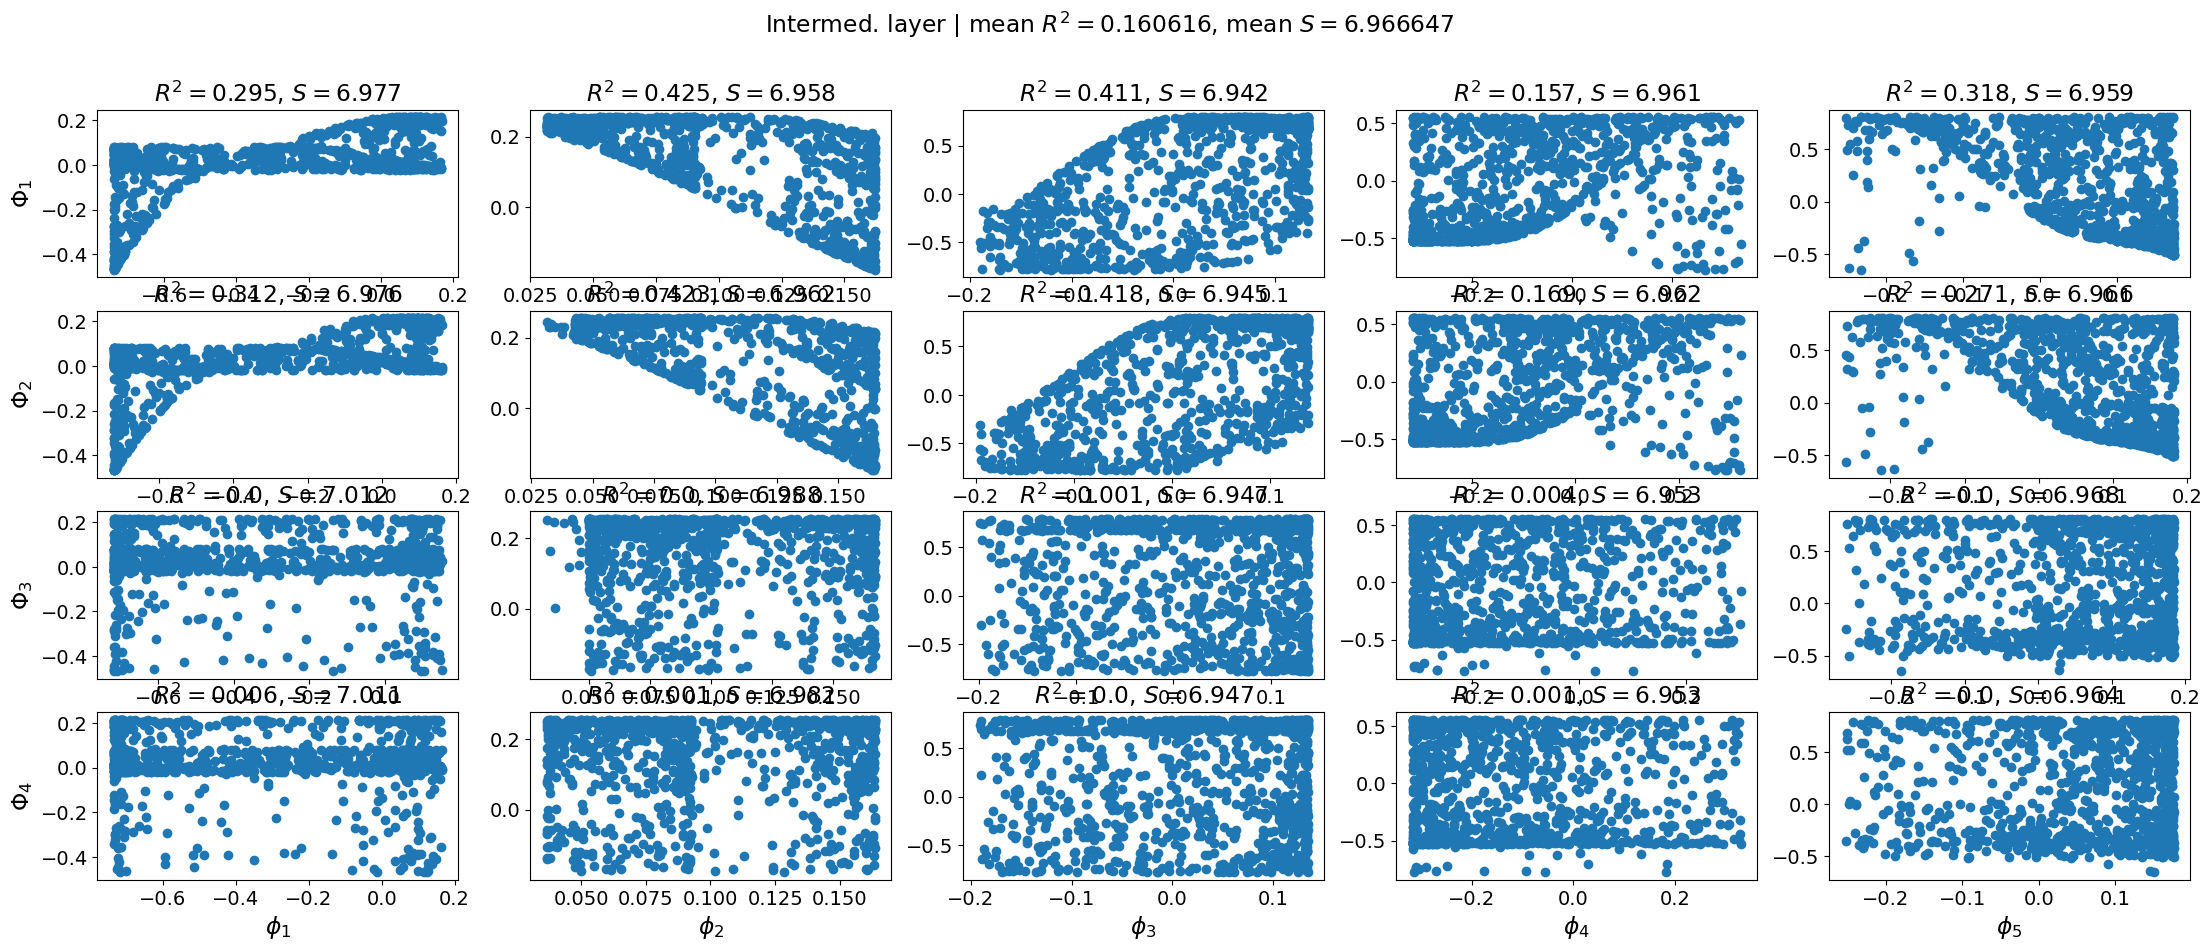

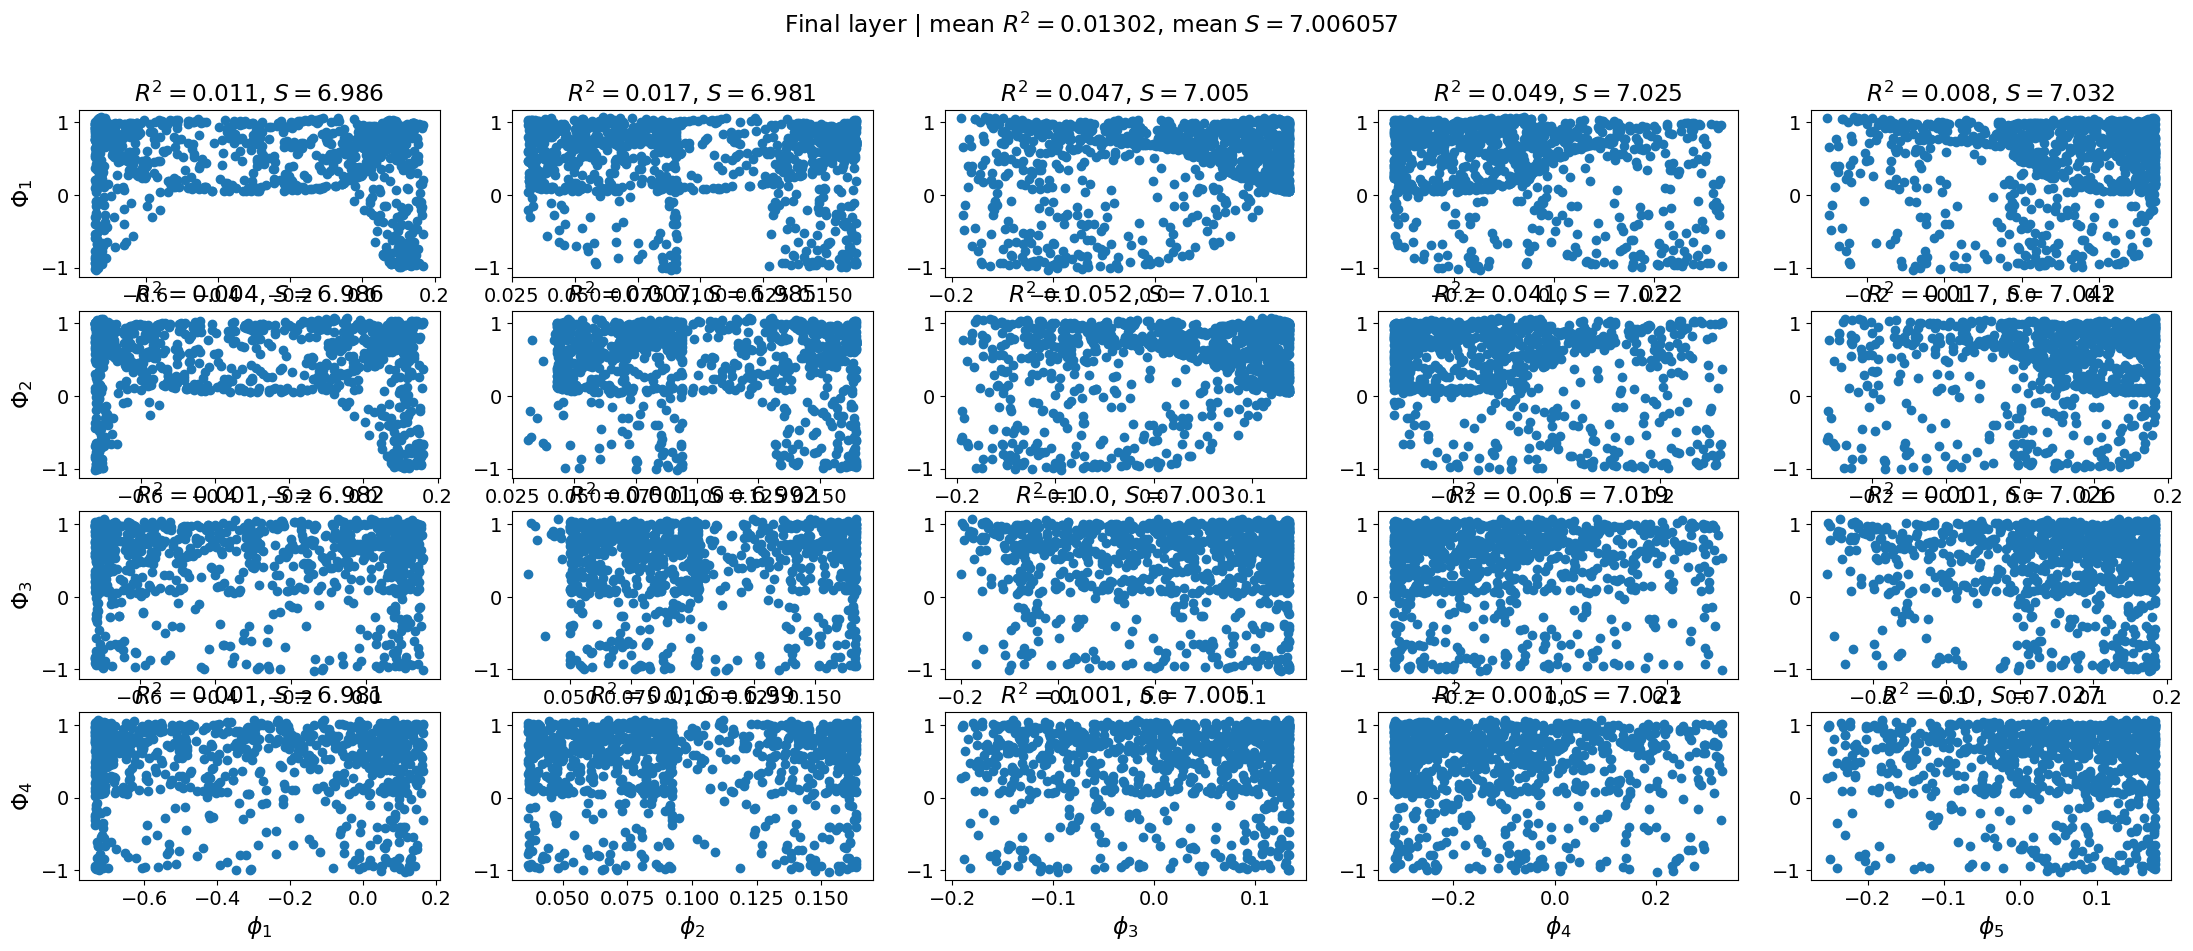

{'mean_r2': 0.0130202521118008, 'mean_matrix_entropy': 7.006056785583496}

In [20]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_2$ with __Entropy regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.35e-02 | test_loss: 2.94e-02 | reg: 1.11e+01 | : 100%|█| 150/150 [05:03<00:00,  2.02


saving model version 0.1


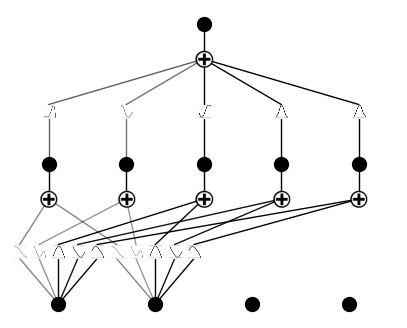

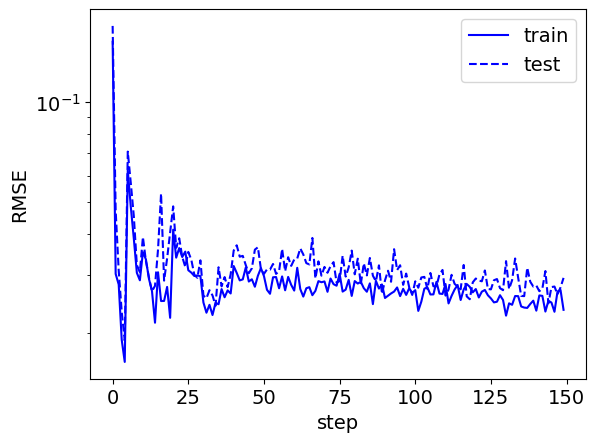

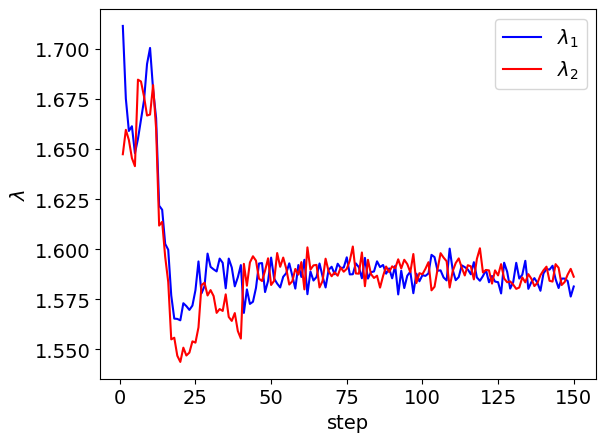

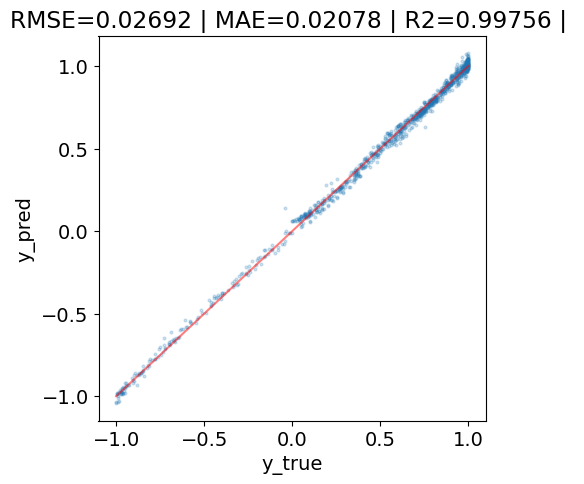

model.act_fun[0].lmd=Parameter containing:
tensor([1.5814e+00, 1.5863e+00, 3.2174e-03, 2.9641e-04], requires_grad=True)


In [21]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [01:17, 11.46it/s]                          


module of Input importance:


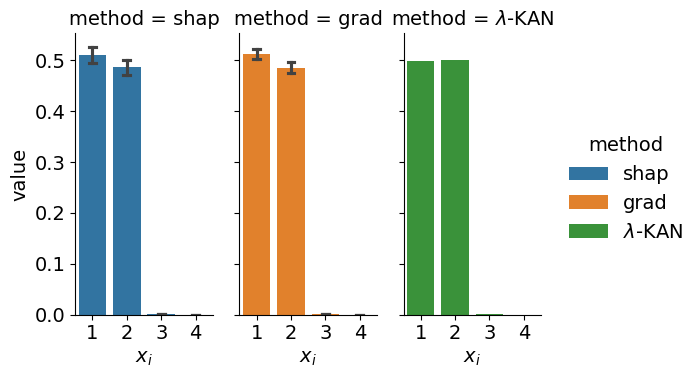

Input importance:


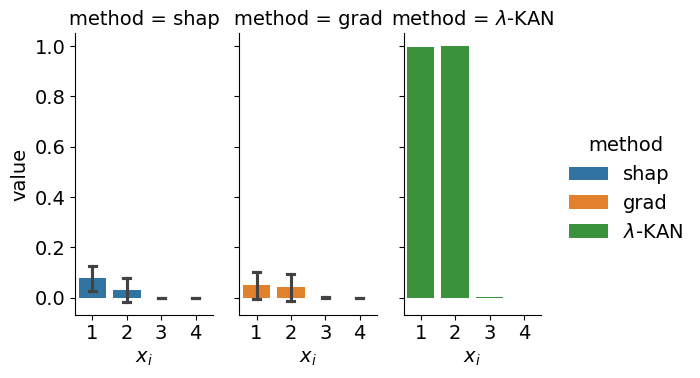

In [22]:
importance_analyse_lmdKAN(model, dataset)

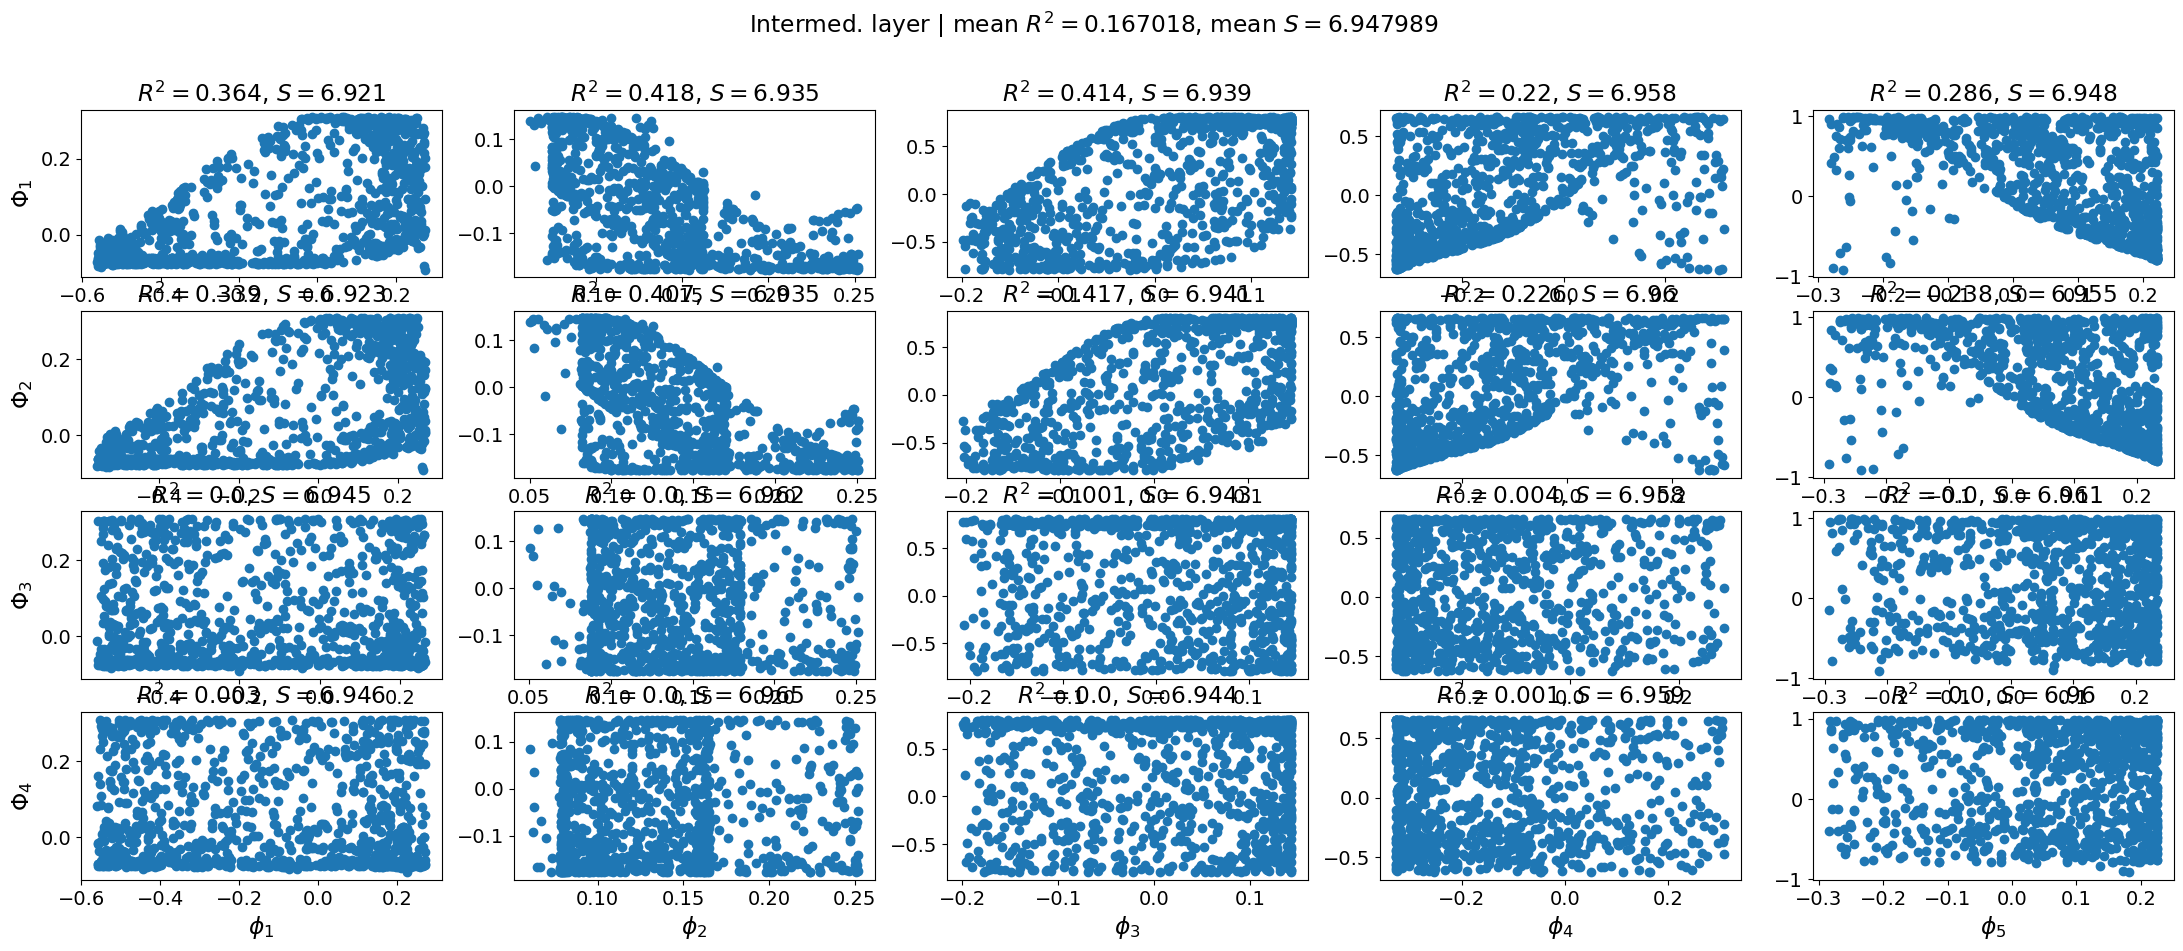

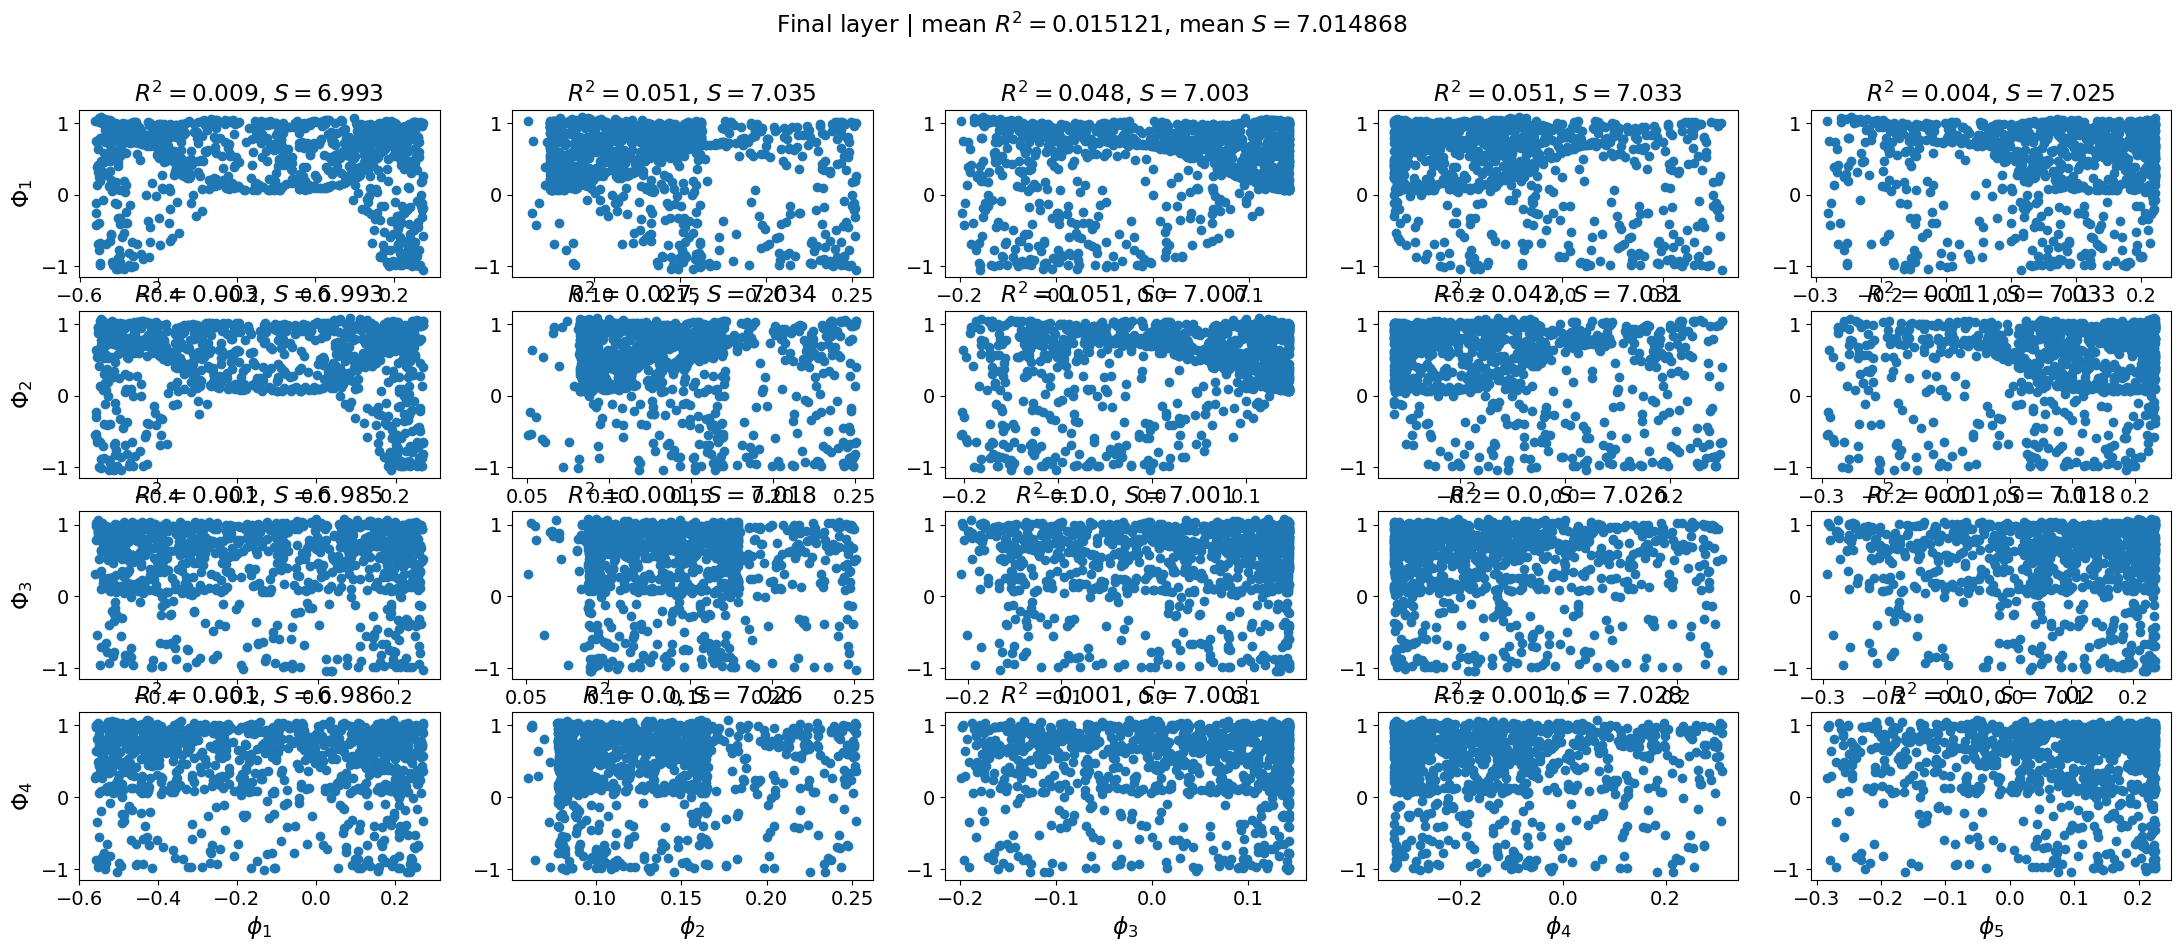

{'mean_r2': 0.01512079279690397, 'mean_matrix_entropy': 7.014868259429932}

In [23]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')